In [8]:
import pandas as pd 
import plotly.express as px
import numpy as np
from datetime import datetime
df = pd.read_csv("Walmart_Sales.csv")

| Feature      | Type             | Meaning              |
| ------------ | ---------------- | -------------------- |
| Store        | Categorical (ID) | Store identifier     |
| Weekly_Sales | Numeric          | Target               |
| Holiday_Flag | Binary           | Holiday week or not  |
| Temperature  | Numeric          | Weather              |
| Fuel_Price   | Numeric          | Logistics cost proxy |
| CPI          | Numeric          | Inflation            |
| Unemployment | Numeric          | Demand strength      |


**DATA PREPERATION**

In [9]:
print(df.info())
print(df.describe())
df["Date"] = pd.to_datetime(df["Date"], format='%d-%m-%Y')

# features 
lags = [1, 2, 3, 5, 7, 9, 11]
for i in lags:
    df[f"lag_{i}"] = df.groupby('Store')["Weekly_Sales"].shift(i)

for i in lags:
    df[f"rolling_std_{i}"] = df.groupby('Store')["Weekly_Sales"].shift(i).rolling(window=i).std()

for i in lags:
   
    df[f"rolling_mean_{i}"] = df.groupby('Store')["Weekly_Sales"].shift(i).rolling(window=i).mean()

#pre-holiday sales
df["holiday_lag"] = df["Holiday_Flag"] * df["lag_1"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None
             Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000

**EDA**

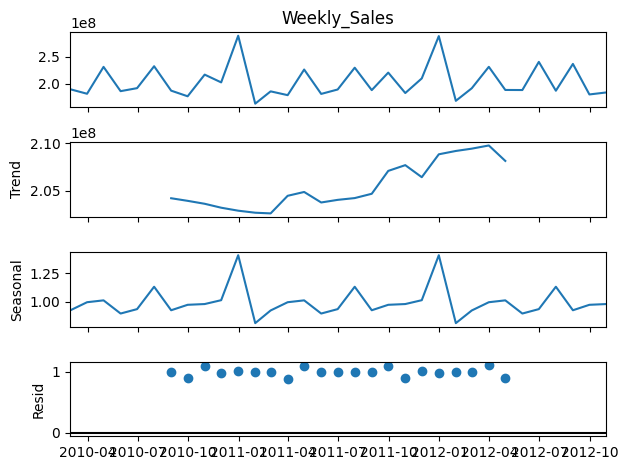

shape(33, 1)
P-value0.0001

LjungBox Test —          lb_stat  lb_pvalue
10  51365.901851        0.0
20  95404.594833        0.0
         lb_stat  lb_pvalue
10  51365.901851        0.0
20  95404.594833        0.0


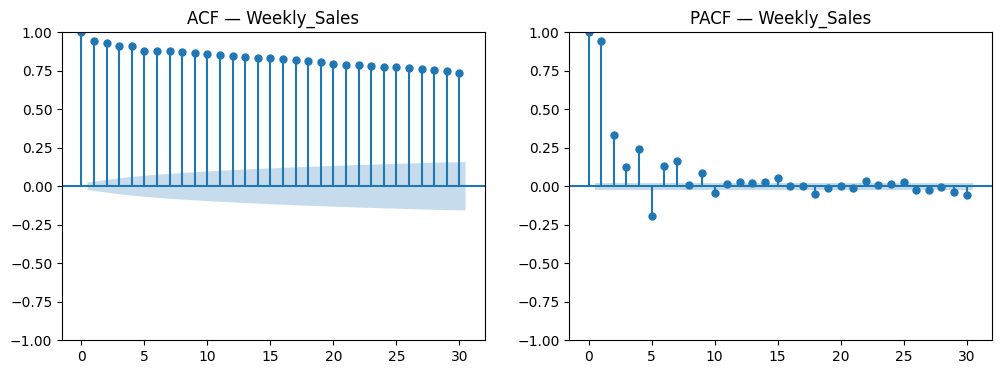

(6435, 30)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,lag_1,lag_2,...,rolling_std_9,rolling_std_11,rolling_mean_1,rolling_mean_2,rolling_mean_3,rolling_mean_5,rolling_mean_7,rolling_mean_9,rolling_mean_11,holiday_lag
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,723086.20,702238.27,...,47282.301707,29939.884466,723086.20,734375.465,739680.930000,722233.520,753513.992857,788019.565556,801296.578182,0.0
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,713173.95,723086.20,...,47397.849013,35322.937113,713173.95,712662.235,734349.600000,726758.778,746246.738571,775640.107778,797234.120909,0.0
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,733455.07,713173.95,...,48707.087551,43322.254126,733455.07,718130.075,730612.376667,734915.408,728371.190000,768740.587778,791887.230909,0.0
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,734464.36,733455.07,...,46428.880921,47488.867740,734464.36,723314.510,712832.806667,728755.598,726154.160000,757740.448889,785058.797273,0.0
6434,45,2012-10-26,760281.43,0,58.85,3.882,192.308899,8.667,718125.53,734464.36,...,40917.121342,48515.742715,718125.53,733959.715,723238.406667,728873.452,730282.590000,746147.460000,777358.447273,0.0


In [10]:
corr = df.drop('Date', axis = 1).corr()
fig=px.imshow(corr, text_auto= True)
fig.show()

groupby_max_sales = df.groupby("Store")["Weekly_Sales"].max()
px.bar(groupby_max_sales).show()

groupby_week_sales = df.groupby(pd.Grouper(key = "Date", freq = "ME"))["Weekly_Sales"].sum()

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
groupby_week_sales = groupby_week_sales.to_frame(name='Weekly_Sales')
groupby_week_sales = groupby_week_sales.reset_index()
groupby_week_sales['Date'] = pd.to_datetime(groupby_week_sales['Date'], errors='coerce')
groupby_week_sales.set_index('Date', inplace=True)
groupby_week_sales.index.freq = 'ME' 



result = seasonal_decompose(groupby_week_sales['Weekly_Sales'], model="multiplicative")
result.plot()
plt.show()
print(f'shape{groupby_week_sales.shape}')
px.line(groupby_week_sales)


from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def adf_test(series):
    result = adfuller(series, autolag="AIC")
    return print(f"P-value{result[1]:.4f}")
def white_noise_acorr_ljungbox_test(series):
    lb = acorr_ljungbox(series, lags=[10, 20], return_df=True)
    print(f"\nLjungBox Test — {lb}")
    print(lb)

adf_test(series=df['Weekly_Sales'])
white_noise_acorr_ljungbox_test(series=df['Weekly_Sales'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df["Weekly_Sales"], lags=30, ax=ax[0])
plot_pacf(df["Weekly_Sales"], lags=30, ax=ax[1])
ax[0].set_title("ACF — Weekly_Sales")
ax[1].set_title("PACF — Weekly_Sales")
plt.show()

print(df.shape)

df.tail()


**MODELING**

In [11]:
train = df.iloc[1000:]
test =  df.iloc[:1000]

feature = [
    'Store',
    'Holiday_Flag',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'lag_1',
    'lag_2',
    'lag_3',
    'lag_5',
    'lag_7',
    'lag_9',
    'lag_11',
    'rolling_std_1',
    'rolling_std_2',
    'rolling_std_3',
    'rolling_std_5',
    'rolling_std_7',
    'rolling_std_9',
    'rolling_std_11',
    'rolling_mean_1',
    'rolling_mean_2',
    'rolling_mean_3',
    'rolling_mean_5',
    'rolling_mean_7',
    'rolling_mean_9',
    'rolling_mean_11',
    'holiday_lag'
]
x_train = train[feature]
y_train = train['Weekly_Sales']
x_test = test[feature]
y_test = test['Weekly_Sales']

from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_estimators = 1000, 
                      max_depth = 50,
                      min_samples_leaf=100,
                      n_jobs=-1)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)  


**MODEL EVALUATION**

In [12]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2_score_ = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("r2_score", r2_score_)

MAE: 88630.65277662055
RMSE: 407.0656562456588
r2_score 0.9467250715130027


**MODELDEPLOYMENT**

lag_1 0.4518777064588277
rolling_mean_1 0.4502011675440934
lag_2 0.07414124474931116
rolling_mean_2 0.016210502395679224
rolling_mean_3 0.005740839486885466
rolling_mean_5 0.00033691370186262286
lag_3 0.00025039315650919185
rolling_std_9 0.0002246945447530809
Temperature 0.00017059469609836806
lag_9 0.00013276980636251834
rolling_mean_11 0.00011506077319874938
Store 0.00010621473820319467
lag_7 0.0001016724514697602
CPI 9.552470771524498e-05
rolling_mean_9 6.082692630783829e-05
rolling_std_2 5.986327734813132e-05
rolling_std_5 4.530534368322415e-05
rolling_mean_7 2.6754949041983636e-05
rolling_std_11 2.6038406533350132e-05
Fuel_Price 2.080919349601902e-05
lag_11 1.9916724388151534e-05
Unemployment 1.3989282680558561e-05
rolling_std_3 7.975133747905723e-06
lag_5 7.477270528875732e-06
rolling_std_7 5.744281274162119e-06
Holiday_Flag 0.0
rolling_std_1 0.0
holiday_lag 0.0


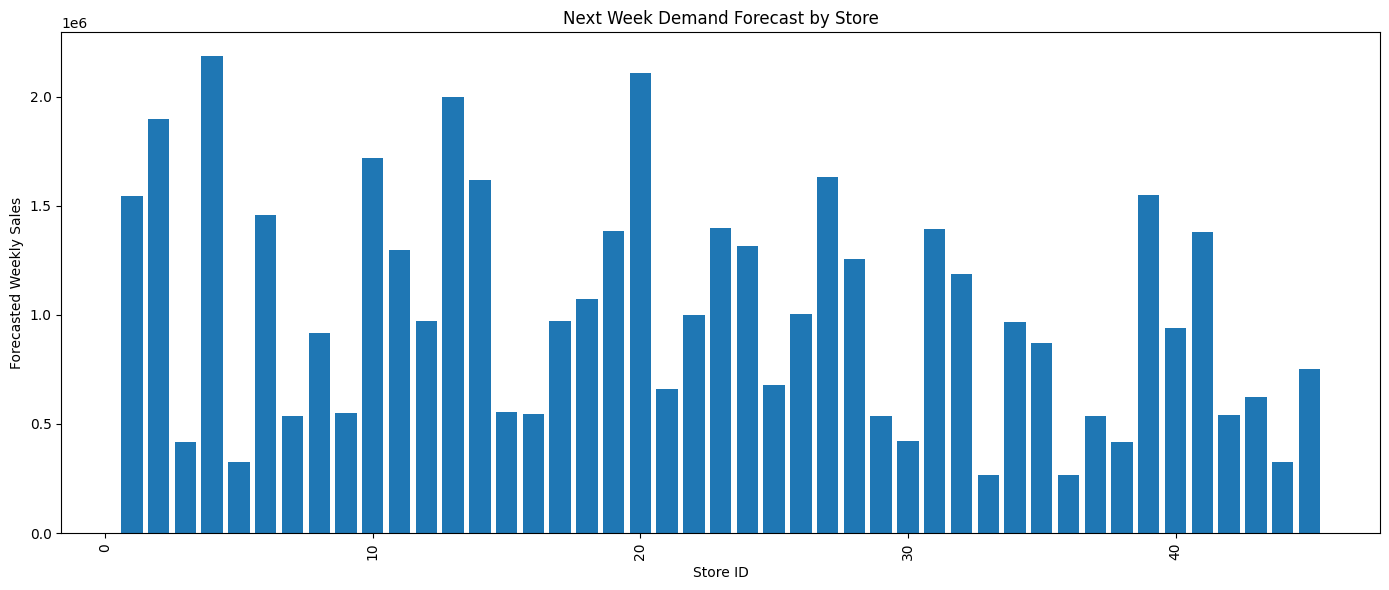

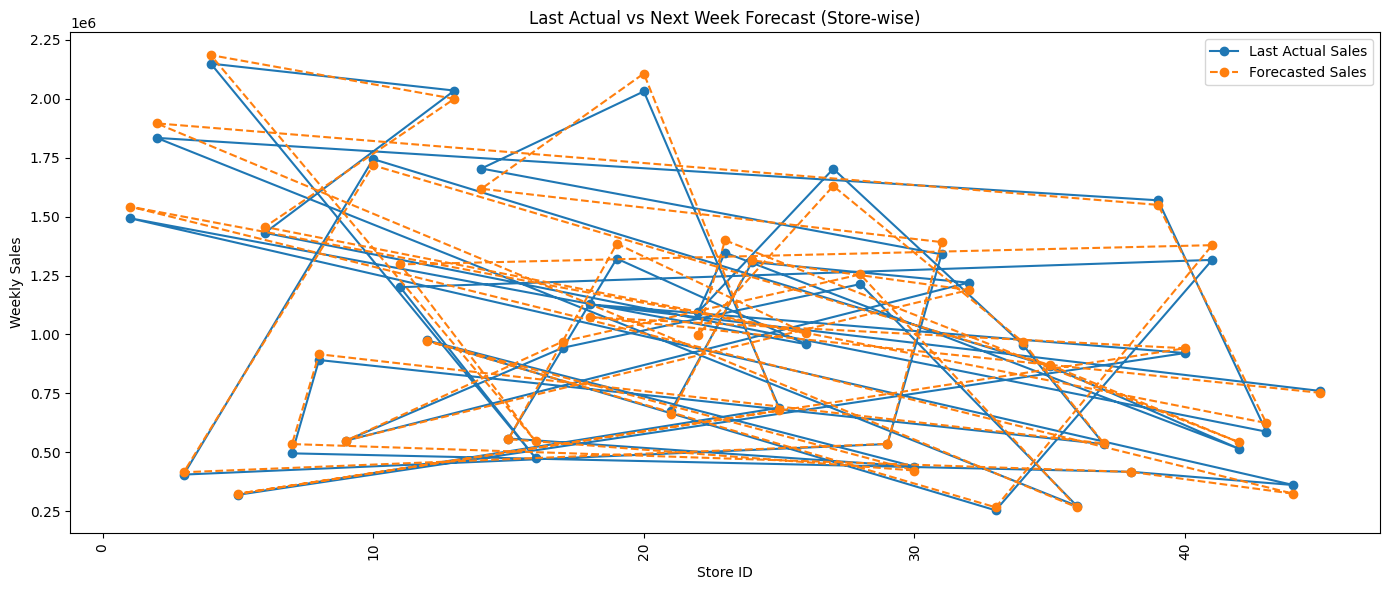

In [13]:

importances = model.feature_importances_
for f, imp in sorted(zip(feature, importances), key=lambda x: x[1], reverse=True):
    print(f, imp)
def forecast_next_week(last_row, model, feature):
    X = last_row[feature].to_frame().T
    return model.predict(X)[0]


forecasts = {}

for store_id in df["Store"].unique():
    last_row = (
        df[df["Store"] == store_id]
        .sort_values("Date")
        .iloc[-1]
    )
    
    forecasts[store_id] = forecast_next_week(
        last_row=last_row,
        model=model,
        feature=feature
    )

import pandas as pd

forecast_df = pd.DataFrame(
    list(forecasts.items()),
    columns=["Store", "Forecast_Weekly_Sales"]
)

forecast_df = forecast_df.sort_values("Store")
forecast_df.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(
    forecast_df["Store"],
    forecast_df["Forecast_Weekly_Sales"]
)

plt.xlabel("Store ID")
plt.ylabel("Forecasted Weekly Sales")
plt.title("Next Week Demand Forecast by Store")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()




last_actual = (
    df.sort_values("Date")
      .groupby("Store")
      .tail(1)[["Store", "Weekly_Sales"]]
)

comparison = last_actual.merge(
    forecast_df,
    on="Store",
    how="inner"
)

plt.figure(figsize=(14, 6))

plt.plot(
    comparison["Store"],
    comparison["Weekly_Sales"],
    marker="o",
    label="Last Actual Sales"
)

plt.plot(
    comparison["Store"],
    comparison["Forecast_Weekly_Sales"],
    marker="o",
    linestyle="--",
    label="Forecasted Sales"
)

plt.xlabel("Store ID")
plt.ylabel("Weekly Sales")
plt.title("Last Actual vs Next Week Forecast (Store-wise)")
plt.legend()
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

